<a href="https://colab.research.google.com/github/snaiws/NLP_project/blob/koelectra%2Fbase-v3/Model_koelectra_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# transformer, datset 설치
!pip install transformers datasets
#progress bar
!pip install fastprogress
# Hyperparameter 탐색: optuna 설치
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# tensorboard 패키지 설치
!pip install jupyter-tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# tensorboard extension 설치
%load_ext tensorboard

In [4]:
import os
import copy
import json
import logging
import re
from tqdm import tqdm

# Data
import pandas as pd
import json
import numpy as np
import random
import torch
import transformers
from numpy.lib.function_base import average
from sklearn.model_selection import train_test_split
from datasets import load_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_

# Visualize Loss 
import seaborn as sns
import matplotlib.pyplot as plt


# Modeling
from transformers import ElectraConfig, ElectraTokenizer, ElectraForSequenceClassification, ElectraModel
from transformers import get_linear_schedule_with_warmup, AdamW
from transformers import EarlyStoppingCallback

# Train
from fastprogress.fastprogress import master_bar, progress_bar

In [5]:
# seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


In [6]:
#reset gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

# AUGMENT

In [7]:
# argument setting
train_batch_size = 32
eval_batch_size = 64
epochs=20
patience=2

num_label = 1
max_seq_len=128
learning_rate=5e-5
adam_epsilon = 1e-8

model_checkpoint = "monologg/koelectra-base-v3-discriminator"
model_type = "koelectra-base-v3"
tokenizer = ElectraTokenizer.from_pretrained(model_checkpoint, do_lower_case=False)

# DATA FUNC

### Data prepare

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
cd /content/drive/MyDrive/AIBootCamp/NLP

/content/drive/MyDrive/AIBootCamp/NLP


In [10]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")

My current directory : /content/drive/MyDrive/AIBootCamp/NLP


In [11]:
train_all = pd.read_json('./data/klue-sts-v1.1/klue-sts-v1.1_train.json')
test = pd.read_json('./data/klue-sts-v1.1/klue-sts-v1.1_dev.json')

In [12]:
# 중복제거
train_all = train_all.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
test = test.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)

In [13]:
train, valid = train_test_split(train_all, test_size=0.1, random_state=seed)

### Data Utils

In [14]:
def make_seed_dataset(df):
    # sentence pairs
    sent_pairs = [(sent1, sent2) for sent1, sent2 in zip(df['sentence1'], df['sentence2'])]
    
    # labels(float)
    labels = [label['real-label'] for label in df['labels']]

    # labels(binary)
    b_labels = [label['binary-label'] for label in  df['labels']]
    
    return sent_pairs, labels, b_labels

def encode(tokenizer, sent_pairs):
    batch_encoding = tokenizer.batch_encode_plus(
                              [(pairs[0], pairs[1]) for pairs in tqdm(sent_pairs, total=len(sent_pairs))], # total : int, 전체 반복량
                              max_length=max_seq_len,
                              padding="max_length",    
                              add_special_tokens=True,
                              truncation=True,
                              )
    return batch_encoding

def make_features(sent_pairs, batch_encoding, labels):
    features = []
    for i in tqdm(range(len(sent_pairs)), total=len(sent_pairs)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}
        if "token_type_ids" not in inputs:
            inputs["token_type_ids"] = [0] * len(inputs["input_ids"])

        feature = {'input_ids':inputs['input_ids'],
                  'attention_mask':inputs['attention_mask'],
                  'token_type_ids':inputs['token_type_ids'],
                  'label':labels[i]
                  }
        
        features.append(feature)
    
    return features

def make_inputs(features):
    # inputs
    all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)

    # label
    try:
      all_labels = torch.tensor([f['label'] for f in features], dtype=torch.float)
    except:
        raise TypeError # dtype change to torch.float

    # dataset
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    return dataset

def make_dataloader(dataset, mode:str):
    assert mode in ['train', 'valid', 'test']

    if mode == "train":
        dataloader = DataLoader(dataset = dataset, # (input_ids, attention_mask, token_type_ids, labels)
                                sampler = RandomSampler(dataset), 
                                batch_size = train_batch_size)
    elif mode == "valid":
        dataloader = DataLoader(dataset = dataset, 
                                sampler = RandomSampler(dataset), 
                                batch_size = eval_batch_size)
    elif mode == "test":
        dataloader = DataLoader(dataset = dataset, 
                                sampler = SequentialSampler(dataset), 
                                batch_size = eval_batch_size)
    else:
        raise AssertionError(mode) # write mode

    return dataloader

## DATA SET

In [15]:
# train dataset
t_sent_pairs, t_labels, t_b_labels = make_seed_dataset(train)

# validation dataset
v_sent_pairs, v_labels, v_b_labels = make_seed_dataset(valid)

# dev dataset
d_sent_pairs, d_labels, d_b_labels = make_seed_dataset(test)

In [16]:
# Encoding
encoded_train = encode(tokenizer, t_sent_pairs)
encoded_valid = encode(tokenizer, v_sent_pairs) 
encoded_test = encode(tokenizer, d_sent_pairs)

100%|██████████| 519/519 [00:00<00:00, 617544.33it/s]


In [17]:
# Get features 
train_features = make_features(t_sent_pairs, encoded_train, t_labels)
valid_features = make_features(v_sent_pairs, encoded_valid, v_labels)
test_features = make_features(d_sent_pairs, encoded_test, d_labels)

100%|██████████| 519/519 [00:00<00:00, 90713.16it/s]


In [18]:
# make inputs
train_dataset = make_inputs(train_features)
valid_dataset = make_inputs(valid_features)
test_dataset = make_inputs(test_features)

In [19]:
# data loader
train_dataloader = make_dataloader(train_dataset, mode='train')
valid_dataloader = make_dataloader(valid_dataset, mode='valid')
dev_dataloader = make_dataloader(test_dataset, mode='test')

# Preset(logging, DIR, metric)

In [20]:
_CUR_DIR

'/content/drive/MyDrive/AIBootCamp/NLP'

In [21]:
# 텐서보드 dir 정의 
logdir_path = os.path.join(_CUR_DIR,"KoELECTRA/koelectra_log") # log 파일을 저장할 경로를 지정 
writer = SummaryWriter(logdir_path)

In [22]:
# '__main__' 이름의 logger 생성
logger = logging.getLogger(__name__)

In [23]:
save_path = os.path.join(_CUR_DIR,"KoELECTRA/koelectra_tensor")

In [24]:
# f1과 pearson 메트릭 불러오기 
metric_f1 = load_metric("f1") 
metric_pearson = load_metric("pearsonr")

# TRAIN

### Train Utils

In [25]:
args = {"model_type": "koelectra-base-v3"}

In [34]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, epoch, loss):
        file_name = f'{self.path}/model.ckpt.best_{epoch}'
        
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss' : loss
            }, 
            file_name
        )
      
        print(f"Saving epoch {epoch} checkpoint at {file_name}")

In [27]:
def init_logger():
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )


def compute_metrics(labels, preds):
    predict_f1 = [1 if i>=3.0 else 0 for i in preds] # 3.0 이상-> 1, 3.0 미만 -> 0으로 변환
    labels_f1 = [1 if i>=3.0 else 0 for i in labels] # 3.0 이상-> 1, 3.0 미만 -> 0으로 변환

    pr = metric_pearson.compute(predictions=preds, # peason r 계산
                                   references=labels)

    f1 = metric_f1.compute(predictions=predict_f1,   # f1
                                     references=labels_f1)
    return {'pearsonr' : pr,
             'f1' : f1}

In [28]:
def validate(model, valid_dataloader, mode, global_step=None):
    results = {}

    # Eval!
    if global_step != None:
        logger.info("***** Running evaluation on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running evaluation on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(valid_dataset)))
    logger.info("  Eval Batch size = {}".format(eval_batch_size))
    
    loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    
    for batch in progress_bar(valid_dataloader):
        model.eval()
        batch = tuple(item.to(device) for item in batch)

        # no_grad
        with torch.no_grad():
            # inputs
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # outputs
            outputs = model(**inputs)

            # loss and logits
            tmp_eval_loss, logits = outputs[:2]
            loss += tmp_eval_loss.mean().item()

        nb_eval_steps += 1
        # Get preds and out_label_ids
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    # average valid loss per epoch
    loss = loss / nb_eval_steps
    
    # preds depending on the type of task
    preds = np.argmax(preds, axis=1)

    # Pearson correlation coefficient and Spearman correlation coefficient
    result = compute_metrics(out_label_ids, preds)
    results.update(result)

    return results, loss

In [32]:
def train(model, train_dataloader, valid_dataloader=None):
    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True, path=save_path)
    
    # train loss and val loss per epoch
    avg_tr_loss = []
    avg_val_loss = []

     # Prepare optimizer and schedule
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0}
    ]

    # train total steps
    total_steps  = len(train_dataloader) * epochs

    optimizer = AdamW(optimizer_grouped_parameters,
                      lr=5e-5,
                      eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    
    
    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataloader))
    logger.info("  Num Epochs = %d", epochs)
    logger.info("  Total train batch size = %d", train_batch_size)
    logger.info("  Total optimization steps = %d", total_steps)

    # Set step and loss
    global_step, batch_step = 0, 0
    tr_loss, batch_loss = 0.0 ,0.0

    # zero_grad
    model.zero_grad()

    # train_dataloaer 학습을 epochs만큼 반복
    mb = master_bar(range(int(epochs)))
    for epoch in tqdm(mb):
        #progress bar
        epoch_iterator = progress_bar(train_dataloader, parent=mb)
        for step, batch in enumerate(epoch_iterator):
            batch_step+=1
            
            # train mode
            model.train()
            
            # inputs to device
            batch = tuple(item.to(device) for item in batch) # tuple(item.to(args.device) for item in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # forward
            outputs = model(**inputs)

            # loss 
            loss = outputs[0]

            # backward
            loss.backward()

            # loss of both batch and tr
            batch_loss += loss.item()
            tr_loss += loss.item()
            
            # gradient clipping (max_norm = 1)
            clip_grad_norm_(model.parameters(), max_norm = 1.0)
                
            # Update optimizer & scheduler
            optimizer.step()
            scheduler.step()

            # initialize gradient by each batch 
            model.zero_grad()
            
            # Print out the batch_loss and the learning rate by every 10 batches
            if (step % 10 == 0 and step != 0):
                learning_rate = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_step:.4f}")
                
                # 학습 loss 기록 tensorboard
                writer.add_scalar(
                    tag = "Train Loss",
                    scalar_value = batch_loss / batch_step,
                    global_step = epoch * len(train_dataloader) + step
                )

                # 학습 learning rate 기록
                writer.add_scalar(
                    tag = "Train LR",
                    scalar_value = optimizer.param_groups[0]['lr'],
                    global_step = epoch * len(train_dataloader) + step
                )

                # Reset batch_loss and batch_step
                batch_loss, batch_step = 0.0, 0
                
            global_step += 1

        # Average train loss per epoch
        avg_train_loss = round(tr_loss / global_step, 4)
        avg_tr_loss.append(avg_train_loss)
        print(f"Epoch {epoch} Train Loss : {avg_tr_loss}")

        # Validate!
        if valid_dataloader is not None:
            print(f"*****Epoch {epoch} Valid Start*****")
            results, val_loss = validate(model, valid_dataloader, "valid", global_step)
            avg_val_loss.append(val_loss)
            print(f"Epoch {epoch} Valid Loss : {val_loss:.4f}")
            print(f"*****Epoch {epoch} Train and Valid Finish*****\n")
            
            # val loss 기록 tensorboard
            writer.add_scalar(
                tag = "Valid Loss",
                scalar_value = val_loss,
                global_step = epoch
            )
        early_stopping(val_loss, model, optimizer, scheduler, epoch)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        else:
          early_stopping.save_checkpoint(model, optimizer, scheduler, epoch, loss)

    print("Train Completed. End Program.")
    writer.close()  #tensorboard기록중지
    return global_step, tr_loss / global_step, avg_tr_loss, avg_val_loss


In [30]:
def main():

    init_logger()
      
    model =  ElectraForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_label).cuda()

    global_step, tr_loss, avg_tr_loss_li, avg_val_loss_li = train(model, train_dataloader, valid_dataloader)
    logger.info(" global_step = {}, average loss = {}".format(global_step, tr_loss))


    return  avg_tr_loss_li, avg_val_loss_li

In [35]:
# 훈련 / 검증
avg_tr_loss_li, avg_val_loss_li = main()

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Epoch: 0, Step : 10, LR : 4.9916158536585364e-05, Avg Loss : 5.5296
Epoch: 0, Step : 20, LR : 4.983993902439025e-05, Avg Loss : 3.2281
Epoch: 0, Step : 30, LR : 4.976371951219512e-05, Avg Loss : 1.4918
Epoch: 0, Step : 40, LR : 4.96875e-05, Avg Loss : 0.4453
Epoch: 0, Step : 50, LR : 4.961128048780488e-05, Avg Loss : 0.4402
Epoch: 0, Step : 60, LR : 4.953506097560976e-05, Avg Loss : 0.4189
Epoch: 0, Step : 70, LR : 4.945884146341463e-05, Avg Loss : 0.4798
Epoch: 0, Step : 80, LR : 4.938262195121951e-05, Avg Loss : 0.2526
Epoch: 0, Step : 90, LR : 4.930640243902439e-05, Avg Loss : 0.3214
Epoch: 0, Step : 100, LR : 4.923018292682927e-05, Avg Loss : 0.2271
Epoch: 0, Step : 110, LR : 4.915396341463414e-05, Avg Loss : 0.2491
Epoch: 0, Step : 120, LR : 4.907774390243903e-05, Avg Loss : 0.2275
Epoch: 0, Step : 130, LR : 4.90015243902439e-05, Avg Loss : 0.2542
Epoch: 0, Step : 140, LR : 4.892530487804878e-05, Avg Loss : 0.2327
Epoch: 0, Step : 150, LR : 4.884908536585366e-05, Avg Loss : 0.2659

06/01/2022 17:20:27 - INFO - __main__ -   ***** Running evaluation on valid dataset (328 step) *****
06/01/2022 17:20:27 - INFO - __main__ -     Num examples = 1167
06/01/2022 17:20:27 - INFO - __main__ -     Eval Batch size = 64


Epoch 0 Train Loss : [0.5567]
*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch 0 Valid Loss : 0.1966
*****Epoch 0 Train and Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_0


1it [02:23, 143.90s/it]

Saving epoch 0 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_0
Epoch: 1, Step : 10, LR : 4.741615853658537e-05, Avg Loss : 0.1476
Epoch: 1, Step : 20, LR : 4.733993902439024e-05, Avg Loss : 0.1482
Epoch: 1, Step : 30, LR : 4.726371951219513e-05, Avg Loss : 0.1345
Epoch: 1, Step : 40, LR : 4.71875e-05, Avg Loss : 0.1290
Epoch: 1, Step : 50, LR : 4.711128048780488e-05, Avg Loss : 0.1365
Epoch: 1, Step : 60, LR : 4.703506097560976e-05, Avg Loss : 0.1357
Epoch: 1, Step : 70, LR : 4.695884146341464e-05, Avg Loss : 0.1297
Epoch: 1, Step : 80, LR : 4.688262195121951e-05, Avg Loss : 0.1290
Epoch: 1, Step : 90, LR : 4.680640243902439e-05, Avg Loss : 0.1346
Epoch: 1, Step : 100, LR : 4.673018292682927e-05, Avg Loss : 0.1516
Epoch: 1, Step : 110, LR : 4.665396341463415e-05, Avg Loss : 0.1534
Epoch: 1, Step : 120, LR : 4.657774390243902e-05, Avg Loss : 0.1259
Epoch: 1, Step : 130, LR : 4.650152439024391e-05, Avg Loss : 0.1723
Epoch: 1, Step : 140, L

06/01/2022 17:22:52 - INFO - __main__ -   ***** Running evaluation on valid dataset (656 step) *****
06/01/2022 17:22:52 - INFO - __main__ -     Num examples = 1167
06/01/2022 17:22:52 - INFO - __main__ -     Eval Batch size = 64


Epoch 1 Train Loss : [0.5567, 0.3464]
*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch 1 Valid Loss : 0.2248
*****Epoch 1 Train and Valid Finish*****

EarlyStopping counter: 1 out of 2


2it [04:42, 140.87s/it]

Saving epoch 1 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_1
Epoch: 2, Step : 10, LR : 4.491615853658537e-05, Avg Loss : 0.1004
Epoch: 2, Step : 20, LR : 4.483993902439025e-05, Avg Loss : 0.1026
Epoch: 2, Step : 30, LR : 4.476371951219512e-05, Avg Loss : 0.0782
Epoch: 2, Step : 40, LR : 4.46875e-05, Avg Loss : 0.0881
Epoch: 2, Step : 50, LR : 4.461128048780488e-05, Avg Loss : 0.1152
Epoch: 2, Step : 60, LR : 4.453506097560976e-05, Avg Loss : 0.1004
Epoch: 2, Step : 70, LR : 4.445884146341463e-05, Avg Loss : 0.0880
Epoch: 2, Step : 80, LR : 4.438262195121952e-05, Avg Loss : 0.1103
Epoch: 2, Step : 90, LR : 4.430640243902439e-05, Avg Loss : 0.0976
Epoch: 2, Step : 100, LR : 4.423018292682927e-05, Avg Loss : 0.1013
Epoch: 2, Step : 110, LR : 4.415396341463415e-05, Avg Loss : 0.1075
Epoch: 2, Step : 120, LR : 4.407774390243903e-05, Avg Loss : 0.0893
Epoch: 2, Step : 130, LR : 4.40015243902439e-05, Avg Loss : 0.0750
Epoch: 2, Step : 140, LR

06/01/2022 17:25:11 - INFO - __main__ -   ***** Running evaluation on valid dataset (984 step) *****
06/01/2022 17:25:11 - INFO - __main__ -     Num examples = 1167
06/01/2022 17:25:11 - INFO - __main__ -     Eval Batch size = 64


Epoch 2 Train Loss : [0.5567, 0.3464, 0.2617]
*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch 2 Valid Loss : 0.1435
*****Epoch 2 Train and Valid Finish*****

Saving epoch 2 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_2


3it [07:07, 142.90s/it]

Saving epoch 2 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_2
Epoch: 3, Step : 10, LR : 4.2416158536585364e-05, Avg Loss : 0.0764
Epoch: 3, Step : 20, LR : 4.2339939024390244e-05, Avg Loss : 0.0650
Epoch: 3, Step : 30, LR : 4.226371951219512e-05, Avg Loss : 0.0547
Epoch: 3, Step : 40, LR : 4.21875e-05, Avg Loss : 0.0768
Epoch: 3, Step : 50, LR : 4.211128048780488e-05, Avg Loss : 0.0672
Epoch: 3, Step : 60, LR : 4.203506097560976e-05, Avg Loss : 0.0721
Epoch: 3, Step : 70, LR : 4.195884146341464e-05, Avg Loss : 0.0669
Epoch: 3, Step : 80, LR : 4.188262195121951e-05, Avg Loss : 0.0723
Epoch: 3, Step : 90, LR : 4.180640243902439e-05, Avg Loss : 0.0799
Epoch: 3, Step : 100, LR : 4.173018292682927e-05, Avg Loss : 0.0688
Epoch: 3, Step : 110, LR : 4.165396341463415e-05, Avg Loss : 0.0720
Epoch: 3, Step : 120, LR : 4.157774390243902e-05, Avg Loss : 0.0655
Epoch: 3, Step : 130, LR : 4.150152439024391e-05, Avg Loss : 0.0653
Epoch: 3, Step : 140,

06/01/2022 17:27:37 - INFO - __main__ -   ***** Running evaluation on valid dataset (1312 step) *****
06/01/2022 17:27:37 - INFO - __main__ -     Num examples = 1167
06/01/2022 17:27:37 - INFO - __main__ -     Eval Batch size = 64


Epoch 3 Train Loss : [0.5567, 0.3464, 0.2617, 0.2134]
*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch 3 Valid Loss : 0.1918
*****Epoch 3 Train and Valid Finish*****

EarlyStopping counter: 1 out of 2


4it [09:27, 141.62s/it]

Saving epoch 3 checkpoint at /content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor/model.ckpt.best_3
Epoch: 4, Step : 10, LR : 3.991615853658537e-05, Avg Loss : 0.0646
Epoch: 4, Step : 20, LR : 3.9839939024390244e-05, Avg Loss : 0.0476
Epoch: 4, Step : 30, LR : 3.976371951219512e-05, Avg Loss : 0.0494
Epoch: 4, Step : 40, LR : 3.96875e-05, Avg Loss : 0.0541
Epoch: 4, Step : 50, LR : 3.961128048780488e-05, Avg Loss : 0.0555
Epoch: 4, Step : 60, LR : 3.9535060975609754e-05, Avg Loss : 0.0532
Epoch: 4, Step : 70, LR : 3.9458841463414634e-05, Avg Loss : 0.0565
Epoch: 4, Step : 80, LR : 3.938262195121951e-05, Avg Loss : 0.0706
Epoch: 4, Step : 90, LR : 3.930640243902439e-05, Avg Loss : 0.0529
Epoch: 4, Step : 100, LR : 3.9230182926829265e-05, Avg Loss : 0.0497
Epoch: 4, Step : 110, LR : 3.915396341463415e-05, Avg Loss : 0.0564
Epoch: 4, Step : 120, LR : 3.9077743902439024e-05, Avg Loss : 0.0462
Epoch: 4, Step : 130, LR : 3.90015243902439e-05, Avg Loss : 0.0518
Epoch: 4, Step : 14

06/01/2022 17:29:56 - INFO - __main__ -   ***** Running evaluation on valid dataset (1640 step) *****
06/01/2022 17:29:56 - INFO - __main__ -     Num examples = 1167
06/01/2022 17:29:56 - INFO - __main__ -     Eval Batch size = 64


Epoch 4 Train Loss : [0.5567, 0.3464, 0.2617, 0.2134, 0.1815]
*****Epoch 4 Valid Start*****


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
4it [11:41, 175.33s/it]
06/01/2022 17:30:00 - INFO - __main__ -    global_step = 1640, average loss = 0.181512268799607


Epoch 4 Valid Loss : 0.1751
*****Epoch 4 Train and Valid Finish*****

EarlyStopping counter: 2 out of 2
Early stopping
Train Completed. End Program.


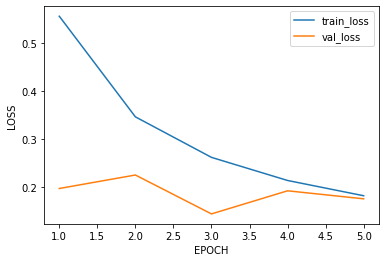

In [37]:
# loss 변화 시각화
val_loss = {'train_loss' : avg_tr_loss_li,
            'val_loss' : avg_val_loss_li,
            'epoch' : [1, 2, 3, 4, 5]}
loss_df = pd.DataFrame(data=val_loss)

sns.lineplot(x='epoch', y='train_loss', data=loss_df, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=loss_df, label='val_loss')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.show();

# PREDICTION

In [43]:
# Load model
path = '/content/drive/MyDrive/AIBootCamp/NLP/KoELECTRA/koelectra_tensor'
checkpoint = torch.load(f'{path}/model.ckpt.best_3')

In [44]:
# ckpt keys
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [45]:
def model_init():
  return ElectraForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_label).cuda()

In [49]:
model = model_init()

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [50]:
# model_state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [75]:
def predict(model, test_dataloader, mode, global_step=None):

    
    if global_step != None:
        logger.info("***** Running test on {} dataset ({} step) *****".format(mode, global_step))
    else:
        logger.info("***** Running test on {} dataset *****".format(mode))
    logger.info("  Num examples = {}".format(len(test_dataset)))
    logger.info("  Eval Batch size = {}".format(eval_batch_size))
    
    # loss, steps, preds, labels
    loss = 0.0
    nb_test_steps = 0
    preds = None
    out_label_ids = None
    
    # Predict !
    model.eval()
    model.to(device)
    for batch in progress_bar(dev_dataloader):
        batch = tuple(item.to(device) for item in batch)

        # no_grad
        with torch.no_grad():
            # inputs
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }

            # outputs
            outputs = model(**inputs)

            # loss and logits
            tmp_test_loss, logits = outputs[:2]
            loss += tmp_test_loss.mean().item()
        
        nb_test_steps += 1

        # preds and labels
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)


    ################################### RETURNS ###################################
    
    # average loss
    loss = loss / nb_test_steps
  

    """ returns info
    preds           :  predictions(float)
    out_label_ids   :  labels(float)
    loss            :  loss of prediction
    """
    return preds, out_label_ids, loss

In [76]:
# Predict !
preds, out_label_ids, loss = predict(model, dev_dataloader, 'test')

06/01/2022 17:51:22 - INFO - __main__ -   ***** Running test on test dataset *****
06/01/2022 17:51:22 - INFO - __main__ -     Num examples = 519
06/01/2022 17:51:22 - INFO - __main__ -     Eval Batch size = 64


In [78]:
pred_bi_label = [1 if i >= 3.0 else 0 for i in preds]

In [57]:
# Metrics
from scipy.stats import pearsonr
from sklearn import metrics as sklearn_metrics

In [83]:
test_f1 = sklearn_metrics.f1_score(d_b_labels, pred_bi_label, average="macro")
test_pearson = pearsonr(d_labels, preds)[0][0]

In [82]:
test_pearson[0]

0.9190657398259657

In [59]:
loss

0.37554966410001117

In [84]:
result = pd.DataFrame({'test_f1' :round( test_f1, 4),
              'test_pearson' : round(test_pearson, 4),
              'test_loss' : round(loss,4)},  index = ['value'])
result

,test_f1,test_pearson,test_loss
value,0.8508,0.9191,0.3755


In [91]:
# score
pred_real_label = [pred[0] for pred in preds]
pred_bi_label = [1 if i >= 3 else 0 for i in preds]


dev_set_score = pd.DataFrame({'guid' : test['guid'],
                              'true_real_label' : d_labels,
                              'true_binary_label' : d_b_labels,
                              'pred_real_label' : pred_real_label,
                              'predict_binary_label' : pred_bi_label })
dev_set_score.head(3)

,guid,true_real_label,true_binary_label,pred_real_label,predict_binary_label
0,klue-sts-v1_dev_00000,4.857143,1,4.947200,1
1,klue-sts-v1_dev_00001,1.428571,0,2.495238,0
2,klue-sts-v1_dev_00002,1.285714,0,1.144429,0


In [92]:
fname = 'koelectra_mine_dev_set_score.csv'
dev_set_score.to_csv(fname)